# TM10007 Assignment Group 5

In [47]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/annawalstra/tm10007_Group5.git
!pip install simpleITK

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

Import packages

The number of spamples: 855
The number of columns: 268


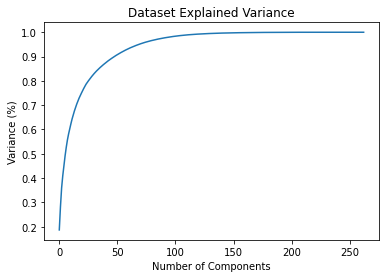

[[ 3.74478921e+00  8.05261649e-01 -3.61940934e+00 ... -8.10808893e-01
  -1.60918816e+00  9.53393112e-03]
 [ 5.99432605e+00 -1.14018770e+01  2.35969622e+00 ...  8.93868630e-01
   1.44084927e+00 -7.90610016e-01]
 [-4.09074374e-01 -3.26262731e-01  2.67768653e+00 ... -2.67852889e-01
   1.25541543e+00  1.54557867e+00]
 ...
 [-4.35621215e+00 -5.56428877e-01  4.75838099e+00 ... -1.81450960e+00
   4.20863665e-01 -1.03802326e-02]
 [-7.47405892e+00 -9.54510095e-01  7.27988255e+00 ... -1.33850090e+00
   6.53923135e-01 -7.40392887e-01]
 [-1.30438639e+00 -6.12509144e+00 -4.54392209e+00 ...  9.15612205e-02
  -4.89924295e-01  3.45611611e-01]]


In [48]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn
import SimpleITK as sitk

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition

# Classifiers and kernels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel


# To learn more about metrics see: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# Data loading functions. Uncomment the one you want to use
from adni.load_data import load_data
data = load_data()
print(f'The number of spamples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Creating X and Y 
X = data.loc[:, data.columns != 'label']
Y = data['label']

# Preprocessing: deleting features with only zeros
X = X.loc[:, (X != 0).any(axis=0)]
# print(f'The number of spamples: {len(X.index)}')
# print(f'The number of columns: {len(X.columns)}')

# Binarize Y labels
y_bin = preprocessing.label_binarize(Y, ['CN','AD'])
y_bin = [i[0] for i in y_bin]
#print(y_bin)

# Split the dataset in train and test part
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y_bin, test_size=0.5, stratify=y_bin)


# Scale the data 
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


#Fitting the PCA algorithm with our Data
from sklearn.decomposition import PCA

pca = PCA().fit(X_train_scaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()


# Perform a PCA
pca = decomposition.PCA(n_components=50)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)





## KNN Classifier

Vraag: met grid_search.best_estimator_ krijg ik als het beste resultaat k=33, maar als ik k=25 invul krijg ik een hoger resultaat voor test en train. 

vgm snap ik dit nu wel...Soms grid_search.best_estimator_ ander resultaat voor beste k dan clf.n_neigbors


In [49]:
# Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
# Specify the classifier
knn = neighbors.KNeighborsClassifier()
parameters = {"n_neighbors": list(range(1, 51, 2))}
cv_10fold = model_selection.StratifiedKFold(n_splits=10)
grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='accuracy')
grid_search.fit(X_train_pca, Y_train)
# Show the complete results of the cross validation
display(pd.DataFrame(grid_search.cv_results_))


# # Fit kNN
# Get resulting classifier
print(grid_search.best_estimator_)
#print(f'Best classifier: k={clf.n_neighbors}')
clf = neighbors.KNeighborsClassifier(n_neighbors=21)
clf.fit(X_train_pca, Y_train)
score_train = clf.score(X_train_pca, Y_train)
score_test = clf.score(X_test_pca, Y_test)

# Get the accuracy
y_pred = clf.predict(X_train_pca)
acc_train=metrics.accuracy_score(Y_train, y_pred)
y_pred = clf.predict(X_test_pca)
acc_test=metrics.accuracy_score(Y_test, y_pred)

# Print result
print(f"Training result: {score_train}")
print(f"Test result: {score_test}")
print(f"Accuracy:")
print(f"Training result: {acc_train}")
print(f"Test result: {acc_test}")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001619,0.000265,0.003586,0.000315,1,{'n_neighbors': 1},0.837209,0.720930,0.604651,0.627907,0.790698,0.674419,0.744186,0.666667,0.809524,0.738095,0.721429,0.073724,25
1,0.001380,0.000049,0.003358,0.000089,3,{'n_neighbors': 3},0.744186,0.744186,0.720930,0.697674,0.883721,0.744186,0.767442,0.595238,0.785714,0.738095,0.742137,0.068279,24
2,0.001391,0.000047,0.003374,0.000053,5,{'n_neighbors': 5},0.790698,0.720930,0.744186,0.744186,0.860465,0.767442,0.744186,0.690476,0.809524,0.761905,0.763400,0.045323,23
3,0.001345,0.000015,0.003400,0.000089,7,{'n_neighbors': 7},0.767442,0.813953,0.767442,0.720930,0.860465,0.744186,0.790698,0.666667,0.761905,0.785714,0.767940,0.049578,22
4,0.001401,0.000068,0.003504,0.000105,9,{'n_neighbors': 9},0.790698,0.813953,0.720930,0.697674,0.837209,0.790698,0.790698,0.738095,0.761905,0.761905,0.770377,0.040646,20
5,0.001347,0.000017,0.003410,0.000046,11,{'n_neighbors': 11},0.790698,0.813953,0.813953,0.720930,0.883721,0.837209,0.790698,0.738095,0.809524,0.785714,0.798450,0.043944,1
6,0.001385,0.000054,0.003540,0.000189,13,{'n_neighbors': 13},0.744186,0.790698,0.790698,0.720930,0.906977,0.860465,0.790698,0.738095,0.785714,0.785714,0.791417,0.053133,2
7,0.001383,0.000041,0.003646,0.000185,15,{'n_neighbors': 15},0.720930,0.790698,0.790698,0.744186,0.906977,0.860465,0.767442,0.761905,0.761905,0.761905,0.786711,0.053187,3
8,0.001376,0.000066,0.003550,0.000072,17,{'n_neighbors': 17},0.720930,0.813953,0.790698,0.744186,0.906977,0.837209,0.790698,0.714286,0.761905,0.761905,0.784275,0.055082,5
9,0.001379,0.000023,0.003617,0.000127,19,{'n_neighbors': 19},0.720930,0.790698,0.767442,0.744186,0.883721,0.883721,0.767442,0.714286,0.738095,0.785714,0.779623,0.057292,10


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')
Training result: 0.7985948477751756
Test result: 0.7827102803738317
Accuracy:
Training result: 0.7985948477751756
Test result: 0.7827102803738317


## KNN with Crossvalidation


Best classifier: k=23
Best classifier: k=25
Best classifier: k=25
Best classifier: k=25
Best classifier: k=23
Best classifier: k=23
Best classifier: k=25
Best classifier: k=23
Best classifier: k=25
Best classifier: k=23
Best classifier: k=23
Best classifier: k=23
Best classifier: k=23
Best classifier: k=15
Best classifier: k=25
Best classifier: k=15
Best classifier: k=23
Best classifier: k=25
Best classifier: k=25
Best classifier: k=25


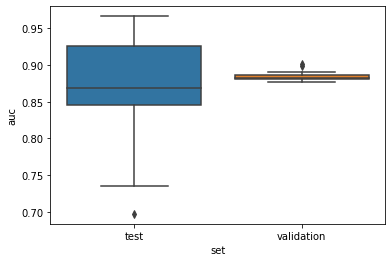

The optimal N=23
0.7780373831775701


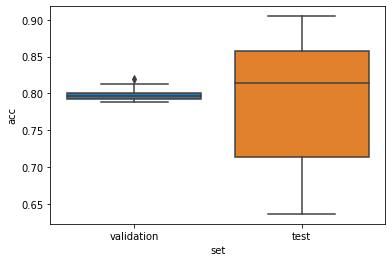

In [50]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=20)
results = []
results_acc = []
best_n_neighbors = []

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_pca, Y_train):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    y_validation = np.array(Y_train)[validation_index]
    
    X_testKNN = X_train_pca[test_index]
    y_testKNN = np.array(Y_train)[test_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 26, 2))}
    knn = neighbors.KNeighborsClassifier()
    cv_10fold = model_selection.StratifiedKFold(n_splits=10)
    grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_testKNN)
    scores = probabilities[:, 1]

    # Get the accuracy
    y_pred = clf.predict(X_validation)
    accuracy=metrics.accuracy_score(y_validation, y_pred)
    results_acc.append({'acc': accuracy,'set': 'validation'})
    y_pred = clf.predict(X_testKNN)
    accuracy = metrics.accuracy_score(y_testKNN, y_pred)
    results_acc.append({'acc': accuracy,'set': 'test'})
    
    # Get the auc
    auc = metrics.roc_auc_score(y_testKNN, scores)
    results.append({'auc': auc,'k': clf.n_neighbors,'set': 'test'})
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
plt.show()
seaborn.boxplot(y='auc', x='set', data=results)
plt.show()
results_acc = pd.DataFrame(results_acc)
seaborn.boxplot(y='acc', x='set', data=results_acc)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")


print(clf.score(X_test_pca, Y_test))

# Support Vector Machine (SVM) Classifier 



In [89]:
# Construct classifiers and corresponding kernel (comment the ones that we do not want to use)

# Linear kernel:
svmlin = SVC(kernel='linear', gamma='scale')
# Radial Basis Function (RBF) kernel:
svmrbf = SVC(kernel='rbf', gamma='scale')
# Polynomial kernel:
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')

# Other options on kernels:
# - change gamma
# - sampler, for example: first use RBF sampler, then linear kernel
# - manually constructed kernel function?
# - precomputed kernel
# - sigmoid kernel

# Possibility: start with linear kernel and then gradually increase complexity
clsfs = [svmlin, svmrbf, svmpoly]

# Create lists of datasets to loop over (klopt dit?)

Xs = X_train_pca
Ys = Y_train

# Important hyperparameters in SVM:
# - degree of the kernel
# - coef0s
# - slacks

# Tune hyperparameters (for now just a couple of examples)
degrees = [1, 3, 5] # degree of the kernel (d) 
coef0s = [0.01, 0.5, 1] # the homogeneity of the kernel (c)
slacks = [0.01, 0.5, 1] # slack parameter (C)
    
clsfs = list() 
for degree in degrees:
    for coef0 in coef0s:
        for slack in slacks:
            clsfs.append(SVC(kernel='linear', degree=degree, coef0=coef0, C=slack, gamma='scale'))


# Now use the classifier on all data
for clsf in clsfs:
  clsf.fit(Xs, Ys)
  y_pred = clsf.predict(Xs)
  print(f"kernel: {clsf.kernel}")
  print(f"degree: {clsf.degree}, coef0: {clsf.coef0}, C: {clsf.C}. ")
  print("Misclassified: %d / %d" % ((Ys != y_pred).sum(), Xs.shape[0]))
  #ax = fig.add_subplot(clsf + 1, 3, num + 1)
  #ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
             #s=25, edgecolor='k', cmap=plt.cm.Paired)
  #colorplot(clsf, ax, X[:, 0], X[:, 1]) 
  #ax.set_title(t)
  #num += 1



kernel: linear
degree: 1, coef0: 0.01, C: 0.01. 
Misclassified: 56 / 427
kernel: linear
degree: 1, coef0: 0.01, C: 0.5. 
Misclassified: 52 / 427
kernel: linear
degree: 1, coef0: 0.01, C: 1. 
Misclassified: 52 / 427
kernel: linear
degree: 1, coef0: 0.5, C: 0.01. 
Misclassified: 56 / 427
kernel: linear
degree: 1, coef0: 0.5, C: 0.5. 
Misclassified: 52 / 427
kernel: linear
degree: 1, coef0: 0.5, C: 1. 
Misclassified: 52 / 427
kernel: linear
degree: 1, coef0: 1, C: 0.01. 
Misclassified: 56 / 427
kernel: linear
degree: 1, coef0: 1, C: 0.5. 
Misclassified: 52 / 427
kernel: linear
degree: 1, coef0: 1, C: 1. 
Misclassified: 52 / 427
kernel: linear
degree: 3, coef0: 0.01, C: 0.01. 
Misclassified: 56 / 427
kernel: linear
degree: 3, coef0: 0.01, C: 0.5. 
Misclassified: 52 / 427
kernel: linear
degree: 3, coef0: 0.01, C: 1. 
Misclassified: 52 / 427
kernel: linear
degree: 3, coef0: 0.5, C: 0.01. 
Misclassified: 56 / 427
kernel: linear
degree: 3, coef0: 0.5, C: 0.5. 
Misclassified: 52 / 427
kernel: l